<a href="https://colab.research.google.com/github/Anand-Deekshit/Model-Photosphere/blob/main/Model_Photosphere_(Na_I_D_line).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL PHOTOSPHERE (Line Profile for Na I D)

# a) Plotting the Na I D line for solar gravity star

## Import the required libraries and the properties of the star with Solar Gravity

In [ ]:
!pip install exojax

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from matplotlib.pyplot import cm
from scipy import interpolate
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.special as special
import math
from exojax.spec import hjert
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [ ]:

K = 1.38 * 10 ** (-16)
log_g = 4.44
metallicity = 0
g = 10 ** log_g


## Read the grid from the file and store the mass and temperatures

In [ ]:
with open('kurucz.txt') as f:
  lines = f.readlines()

masses = []
temps = []
for line in lines[2:]:
  masses.append(float(line.split("       ")[0]))
  temps.append(float(line.split("       ")[1][:-1]))


## The Total Pressure is the mass column times g and the radiation pressure is given by the temperature. The radiation pressure is extremely small so you can ignore it if you want to. We can get P$_g$ by subtracting the radiation pressure from the total pressure.

In [ ]:
total_p = []
radiation_p = []

for mass in masses:
  total_p.append(mass * g)

for temp in temps:
  radiation_p.append(2.52 * 10 ** (-15) * temp ** 4)

P_g = [total_p[i] - radiation_p[i] for i in range(len(total_p))]

## Input all the partition function values, abundances and the ionization potentials for the elements of interest.

In [ ]:

element_name = {
    'H': 'Hydrogen',
    'He': 'Helium',
    'C': 'Carbon',
    'Si': 'Silicon',
    'Fe': 'Iron',
    'Mg': 'Magnesium',
    'Ni': 'Nickle',
    'Cr': 'Chromium',
    'Ca': 'Calcium',
    'K': 'Potassium',
    'Na': 'Sodium'
}

log_partition_fn = {
    'H-': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'H': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.301, 0.4: 0.303},
    'H+': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'He': {1.4: 0, 1.2: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.4: 0},
    'He+': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.301, 0.4: 0.301},
    'C': {1.4: 0.954, 1.2: 0.958, 1.0: 0.964, 0.8: 0.975, 0.6: 0.994, 0.4: 1.037},
    'C+': {1.4: 0.771, 1.2: 0.772, 1.0: 0.773, 0.8: 0.774, 0.6: 0.775, 0.4: 0.782},
    'Si': {1.4: 0.949, 1.2: 0.961, 1.0: 0.976, 0.8: 0.996, 0.6: 1.030, 0.4: 1.111},
    'Si+': {1.4: 0.746, 1.2: 0.750, 1.0: 0.755, 0.8: 0.759, 0.6: 0.764, 0.4: 0.778},
    'Fe': {1.4: 1.372, 1.2: 1.402, 1.0: 1.446, 0.8: 1.519, 0.6: 1.664, 0.4: 2.049},
    'Fe+': {1.4: 1.575, 1.2: 1.604, 1.0: 1.638, 0.8: 1.682, 0.6: 1.749, 0.4: 1.881},
    'Mg': {1.4: 0.001, 1.2: 0.002, 1.0: 0.007, 0.8: 0.027, 0.6: 0.110, 0.4: 0.478},
    'Mg+': {1.4: 0.301, 1.2: 0.301, 1.0: 0.301, 0.8: 0.301, 0.6: 0.304, 0.4: 0.326},
    'Ni': {1.4: 1.447, 1.2: 1.467, 1.0: 1.490, 0.8: 1.521, 0.6: 1.577, 0.4: 1.753},
    'Ni+': {1.4: 0.953, 1.2: 0.988, 1.0: 1.037, 0.8: 1.108, 0.6: 1.215, 0.4: 1.386},
    'Cr': {1.4: 0.917, 1.2: 0.956, 1.0: 1.022, 0.8: 1.141, 0.6: 1.380, 0.4: 1.977},
    'Cr+': {1.4: 0.793, 1.2: 0.813, 1.0: 0.856, 0.8: 0.944, 0.6: 1.125, 0.4: 1.489},
    'Ca': {1.4: 0.010, 1.2: 0.028, 1.0: 0.073, 0.8: 0.181, 0.6: 0.465, 0.4: 1.332},
    'Ca+': {1.4: 0.309, 1.2: 0.320, 1.0: 0.344, 0.8: 0.391, 0.6: 0.483, 0.4: 0.658},
    'K': {1.4: 0.308, 1.2: 0.320, 1.0: 0.351, 0.8: 0.429, 0.6: 0.642, 0.4: 1.329},
    'K+': {1.4: 0.000, 1.2: 0.000, 1.0: 0.000, 0.8: 0.000, 0.6: 0.000, 0.4: 0.000},
    'Na': {1.4: 0.307, 1.2: 0.309, 1.0: 0.320, 0.8: 0.357, 0.6: 0.493, 0.4: 1.043},
    'Na+': {1.4: 0.000, 1.2: 0.000, 1.0: 0.000, 0.8: 0.000, 0.6: 0.000, 0.4: 0.000},
}


ionization_potential = {
    'H': 13.598,
    'H-': 0.754,
    'He': 24.587,
    'C': 11.260,
    'Si': 8.152,
    'Fe': 7.902,
    'Mg': 7.646,
    'Ni': 7.640,
    'Cr': 6.767,
    'Ca': 6.113,
    'K': 4.341,
    'Na': 5.139
}

abundance = {
    'H': 1.00 * 10 ** 0,
    'He': 8.51 * 10 ** (-2),
    'C': 3.31 * 10 ** (-4),
    'Si': 3.55 * 10 ** (-5),
    'Fe': 2.75 * 10 ** (-5),
    'Mg': 3.80 * 10 ** (-5),
    'Ni': 1.78 * 10 ** (-6),
    'Cr': 4.68 * 10 ** (-7),
    'Ca': 2.29 * 10 ** (-6),
    'K': 1.32 * 10 ** (-7),
    'Na': 2.14 * 10 ** (-6)
}

atomic_weight = {
    'H': 1.67 * 10 ** (-24),
    'He': 6.64 * 10 ** (-24),
    'C': 1.99 * 10 ** (-23),
    'Si': 4.66 * 10 ** (-23),
    'Fe': 9.27 * 10 ** (-23),
    'Mg': 4.03 * 10 ** (-23),
    'Ni': 9.74 * 10 ** (-23),
    'Cr': 8.63 * 10 ** (-23),
    'Ca': 6.65 * 10 ** (-23),
    'K': 6.49 * 10 ** (-23),
    'Na': 3.81 * 10 ** (-23)
}



## A function to get the partition function for theta values in between the values given in Gray's book.

In [ ]:
def get_partition_fn(element, theta):
  if theta <= 1.4 and theta >= 1.2:
    return ((10 ** log_partition_fn[element][1.4]) + (10 ** log_partition_fn[element][1.2])) / 2
  elif theta < 1.2 and theta >= 1.0:
    return ((10 ** log_partition_fn[element][1.2])  + (10 ** log_partition_fn[element][1.0])) / 2
  elif theta < 1.0 and theta >= 0.8:
    return ((10 ** log_partition_fn[element][1.0]) + (10 ** log_partition_fn[element][0.8])) / 2
  elif theta < 0.8 and theta >= 0.6:
    return ((10 ** log_partition_fn[element][0.8]) + (10 ** log_partition_fn[element][0.6])) / 2
  elif theta < 0.6 and theta >= 0.4:
    return ((10 ** log_partition_fn[element][0.6]) + (10 ** log_partition_fn[element][0.4])) / 2


## Because the equation has P$_e$ on both sides it can't be solved in a classical manner. We guess for a value of P$_e$ and iterate the equaiton multiple times by replacing the old guess with the calculated value to get a good value for P$_e$ for each point in the grid.

In [ ]:
P_es = []

for i in range(len(temps)):
  P_guess = 1000
  num = 0 # numerator
  den = 0 # denominator
  
  # print(theta)
  for element in abundance.keys():
    for _ in range(1000):
      theta = 5040 / temps[i]
      partition_fn_ionized = get_partition_fn(element + '+', theta)
      partition_fn = get_partition_fn(element, theta)
      
      phi_element = 0.6665 * partition_fn_ionized * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential[element]) / partition_fn

      
      num = num + abundance[element] * (phi_element / P_guess) / (1 + (phi_element / P_guess))
      den = den + abundance[element] * (1 + ((phi_element / P_guess) / (1 + phi_element / P_guess)))
  

      P_e = P_g[i] * num / den
      P_guess = P_e
      
  P_es.append(P_e)

##Calculate the number density of e$^-$

In [ ]:
N_e = [P_es[i] / (K * temps[i]) for i in range(len(temps))]
log_N_e = [math.log10(n) for n in N_e]

## Now that we have the electron pressures at each point in the grid we can find the total number density using (P$_g$ - P$_e$) / KT. 

In [ ]:
N_tot = [(P_g[i] - P_es[i]) /  (K * temps[i]) for i in range(len(temps))]
log_N_tot = [math.log10(n) for n in N_tot]

## Number density of Hydrogen is basically the total number density divided by the sum of the abundances (the definition of abundance).

In [ ]:
total_abundance = 0
for element in abundance.keys():
  total_abundance = total_abundance + abundance[element]
N_H = [N_tot[i] / total_abundance for i in range(len(N_tot))]

## The ion density is the abundance times N$_H$ at that temp.

In [ ]:
N_element = {}
for element in abundance:
  number_density = []
  for i in range(len(temps)):
    N = abundance[element] * N_H[i]
    number_density.append(N)
  N_element[element] = number_density

## We also have to include H$^-$ which we will get from the Saha Eq.

In [ ]:
N_H_minus = []
for i in range(len(temps)):
  theta = 5040 / temps[i]
  phi_H_minus = 0.6665 * get_partition_fn('H', theta) / get_partition_fn('H-', theta) \
  * 2 * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential['H-'])
  N_H_minus.append(N_H[i] * P_es[i] / phi_H_minus)
log_N_H_minus = [math.log10(n) for n in N_H_minus]

##Now to compute the Na I D line at 5890 A$^o$, we need the broading coefficients

In [ ]:
log_C_4 = -15.17
log_C_6 = -31.7
log_gamma_nat = 7.9
gamma_nat = 10 ** log_gamma_nat
log_P_e = [math.log10(P_es[i]) for i in range(len(temps))]
log_P_g = [math.log10(P_g[i]) for i in range(len(temps))]
wavelength = 5890
mu_Na = 23
doppler_width = [4.301 * 10 ** (-7) * wavelength * (temp / mu_Na) for temp in temps]
f = 0.6546
delta_wavelength = 0.1
wavelengths = np.arange(5885, 5895, 0.1)
log_gamma_4 = []
log_gamma_6 = []
wavelength_cgs = wavelength * 10 ** (-8)
R_cgs = 1.0968 * 10 ** (-3)
h_cgs = 6.626 * 10 ** (-27)
alpha_0 = 1.0449 * 10 ** (-26)
for i in range(len(temps)):
  log_gamma_4.append(19 + (2 / 3) * log_C_4 + log_P_e[i] - (5 / 6) * math.log10(temps[i]))
  log_gamma_6.append(19.6 + 0.4 * log_C_6 + log_P_g[i] - 0.7 * math.log10(temps[i]))

Text(0, 0.5, '$\\gamma$')

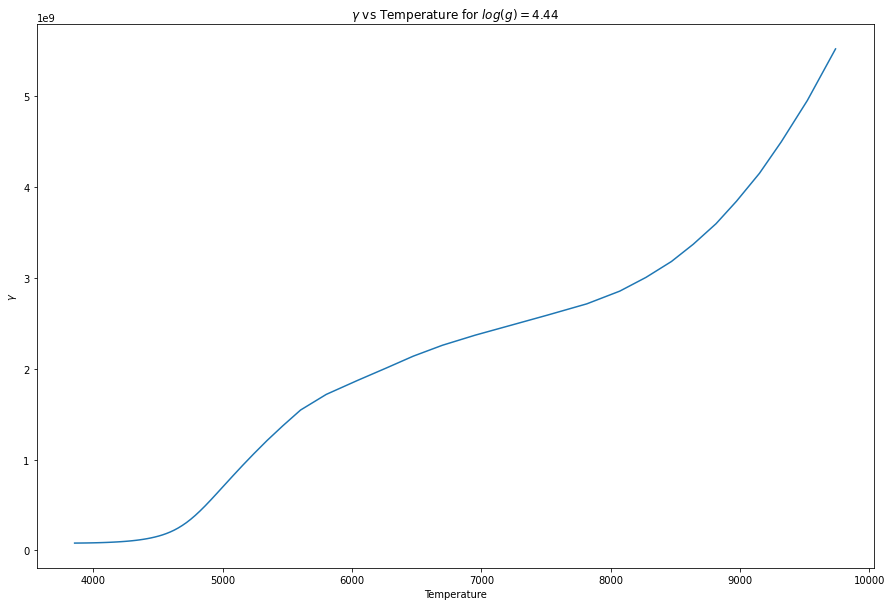

In [ ]:
gamma_4 = [10 ** gamma for gamma in log_gamma_4]
gamma_6 = [10 ** gamma for gamma in log_gamma_6]

gamma = [gamma_nat + gamma_4[i] + gamma_6[i] for i in range(len(temps))]
plt.figure(figsize=[15, 10])
plt.plot(temps, gamma)
plt.title('$\gamma$ vs Temperature for $log(g)=4.44$')
plt.xlabel('Temperature')
plt.ylabel('$\gamma$')

The value of γ seems to be correct because it should increase with temperature because the Pressures increase with temperature

## To find the line coefficient we need the Hjerting function at each wavelength and temperature

Text(0, 0.5, 'H(u, a)')

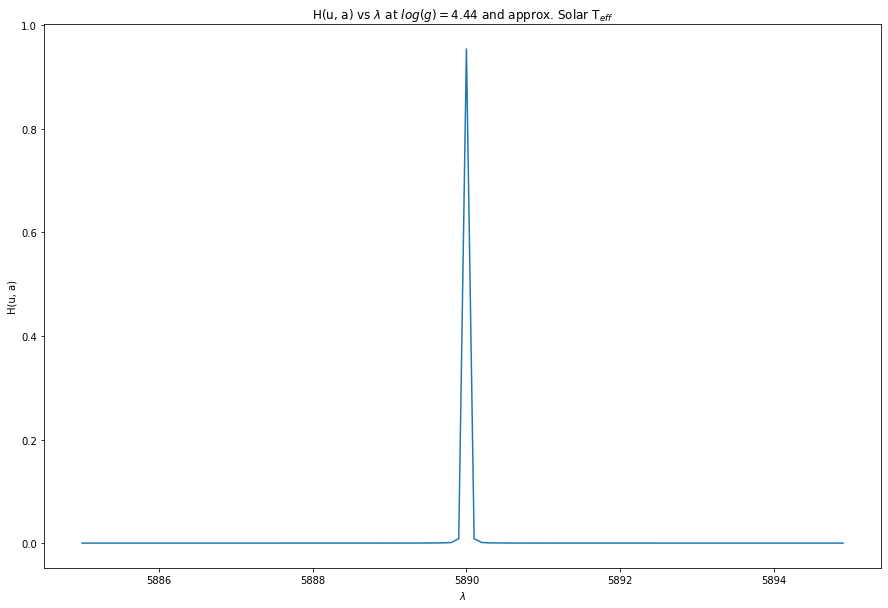

In [ ]:
H = []

for w in wavelengths:
  H_small = []
  for i in range(len(temps)):
    doppler_width = 4.301 * 10 ** (-7) * wavelength * ((temps[i] / mu_Na) ** 0.5)
    a = 2.65 * 10 ** (-20) * gamma[i] * w ** 2 / doppler_width
    u = (w - wavelength) / doppler_width
    H_small.append(hjert(u, a))
  H.append(H_small)
H = np.array(H)
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, H[:, 45])
plt.title('H(u, a) vs $\lambda$ at $log(g)=4.44$ and approx. Solar T$_{eff}$')
plt.xlabel('$\lambda$')
plt.ylabel('H(u, a)')

This is expected of the Hjerting Function, that it should peak at the central line because of the value of Δλ in the u would be 0

##Now we can compute the line coefficient using the equation l$_{λ}$ = 4.995 * 10 $^{-21}$ * λ$_{0}^{2}$ * f * N * H(u, a) * (1 - 10$^{-χθ}$) / (ΣA$_{i}$μ${i}$ * N$_{E}$ * Δλ$_{D}$) at each wavelength and temperature

Text(0.5, 1.0, 'l$_{\\lambda}$ vs $\\lambda$ at approx. Solar T$_{eff}$ and $log(g)=4.44$')

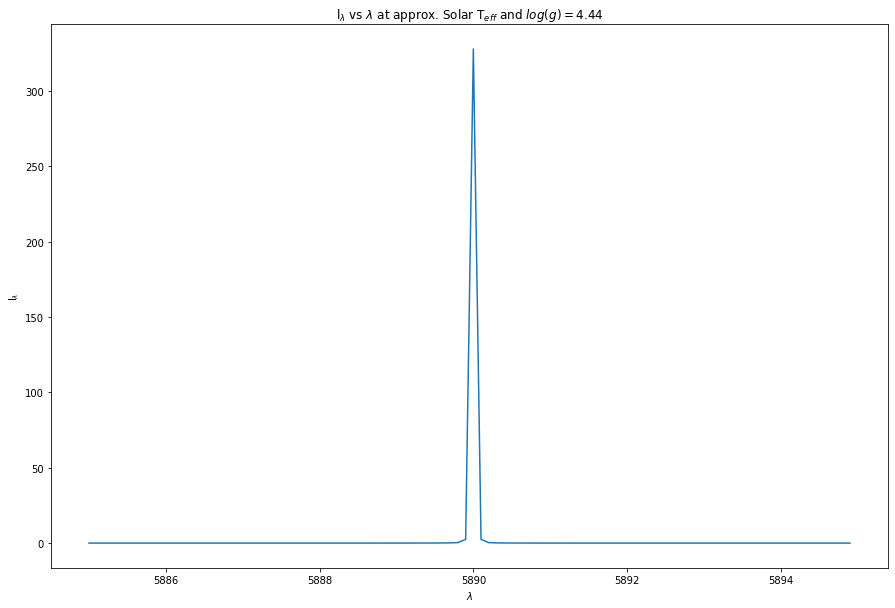

In [ ]:
h = 6.62 * 10 ** (-27)
c = 2.99 * 10 ** (10)
g_Na_1 = 2 #?
sum_weights = 0
for element in abundance.keys():
  sum_weights = sum_weights + abundance[element] * atomic_weight[element]
l = []
for i in range(len(wavelengths)):
  l_w = []
  for j in range(len(temps)):
    theta = 5040 / temps[j]
    phi = 0.6665 * get_partition_fn('Na', theta) / get_partition_fn('Na' + '+', theta) \
      * temps[j] ** (5/2) * 10 ** (-1 * theta * ionization_potential['Na'])
    N_neutral = N_element['Na'][j] / (1 + phi / P_es[j])
    chi = 1.24 * 10 ** 4 / wavelengths[i]
    N_ground = N_neutral * g_Na_1 / get_partition_fn('Na', theta)
    doppler_width = 4.301 * 10 ** (-7) * wavelength * ((temps[j] / mu_Na) ** 0.5)
    l_w.append(4.995 * 10 ** (-21) * wavelength ** 2 * abundance['Na'] * f * N_ground * H[i][j] * (1 - 10 ** (-chi * theta)) / \
              (sum_weights * N_element['Na'][j] * doppler_width))
  l.append(l_w)
l = np.array(l)
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, l[:, 44])
plt.xlabel('$\lambda$')
plt.ylabel('l$_{\lambda}$')
plt.title('l$_{\lambda}$ vs $\lambda$ at approx. Solar T$_{eff}$ and $log(g)=4.44$')

## Calculate the 𝜿$_{ν}$ for Neutral Hydrogen Bound Free



In [ ]:
# H bound-free from n=3, 4, and 5
# not calculating for n = 2 because the photon required for ionization would be in the <3000 Angstorms wavelength
g_bfs = []


k_H_bf = []
for w in wavelengths:
  k_H_bf_small = []
  for temp in temps:
    s = 0
    theta = 5040 / temp
    for n in range(3, 6):
      x = (w * R_cgs / n ** 2) - 0.5
      y = 0.3456 / ((w * R_cgs) ** (1/3))
      g_bf = 1 - x * y
      khi = 13.6 * (1 - (1/n ** 2))
      s = s + w ** 3 * g_bf * 10 ** (-theta * khi) / n ** 3
    k_H_bf_small.append(s * alpha_0)
  k_H_bf.append(k_H_bf_small)

## Calculate the 𝜿$_{ν}$ for H$^-$ Bound Free

In [ ]:
# H- bound-free

a_0 = 1.99654
a_1 = -1.18267 * 10 ** (-5)
a_2 = 2.64243 * 10 ** (-6)
a_3 = -4.40524 * 10 ** (-10)
a_4 = 3.23992 * 10 ** (-14)
a_5 = -1.39568 * 10 ** (-18)
a_6 = 2.78701 * 10 ** (-23)


k_H_minus_bf =[]
for w in wavelengths:
  alpha_bf = a_0 + (a_1 * w) + (a_2 * w ** 2) + (a_3 * w ** 3) + (a_4 * w ** 4) + (a_5 * w ** 5) + (a_6 * w ** 6)
  k_H_minus_bf_small = []
  for i in range(len(temps)):
    theta = 5040 / temps[i]
    k_H_minus_bf_small.append(4.158 * 10 ** (-10) * alpha_bf * P_es[i] * theta ** (5/2) * 10 ** (0.754 * theta) * 10 ** (-18))
  k_H_minus_bf.append(k_H_minus_bf_small)

## Calculate the 𝜿$_{ν}$ for H$^-$ Free-Free

In [ ]:
# H- free-free
k_H_minus_ff = []
for w in wavelengths:
  f_0 = -2.2763 - 1.6850 * math.log(w, 10) + 0.76661 * math.log(w, 10) ** 2 - 0.053346 * math.log(w, 10) ** 3
  f_1 = 15.2827 - 9.2846 * math.log(w, 10) + 1.99381 * math.log(w, 10) ** 2 - 0.142631 * math.log(w, 10) ** 3
  f_2 = -197.789 + 190.266 * math.log(w, 10) - 67.9775 * math.log(w, 10) ** 2 + 10.6913 * math.log(w, 10) ** 3 - 0.625151 * math.log(w, 10) ** 4
  k_H_minus_ff_small = []
  for i in range(len(temps)):
    theta = 5040 / temps[i]
    k_H_minus_ff_small.append(10 ** (-26) * P_es[i] * 10 ** (f_0 + f_1 * math.log(theta, 10) + f_2 * math.log(theta, 10) ** 2))
  k_H_minus_ff.append(k_H_minus_ff_small)

## Calculate the 𝜿$_{ν}$ for H$^-$ Electon scattering

In [ ]:
# electron scattering
alpha_e = 0.6648 * 10 ** (-24)
sum_abundances = 0
for element in abundance.keys():
  sum_abundances = sum_abundances + abundance[element]
k_e = []
for w in wavelengths:
  k_e_small = []
  for i in range(len(temps)):
    k_e_small.append(alpha_e * P_es[i] * sum_abundances / (P_g[i] - P_es[i]))
  k_e.append(k_e_small)

##Add them up to get the final 𝜅$_ν$

In [ ]:
k_total = []
for i in range(len(wavelengths)):
  k_total_small = []
  for j in range(len(temps)):
    k_total_small.append((k_H_bf[i][j] + k_H_minus_bf[i][j] + k_H_minus_ff[i][j] + k_e[i][j]) / (1.66 * 10 ** -24))
  k_total.append(np.array(k_total_small))
k_total = np.array(k_total)

## Exponent integral function

In [ ]:
def expo_integrand(t, n, tau):
  return np.exp(-tau*t) / t**n

def get_expo_fn(n, tau):
  return quad(expo_integrand, 1, np.inf, args=(n, tau))[0]

## Now we can compute the flux ratio

The optical depth of the continumm would be τ$_c$ = 𝜅$_{\nu}$ρx, where ρx is the mass column at that depth and the optical depth for the line would be τ$_{l+c}$=(𝜅$_\nu$+l$_\nu$)ρx. F$_{λ}$=∫B$_ν$(T)E$_2$(τ$_{l+c}$)dτ$_{l+c}$ and F$_{c}$=∫B$_ν$(T)E$_2$(τ$_{c}$)dτ$_{c}$, where dτ$_{l+c}$ = (𝜅$_\nu$+l$_\nu$)ρdx and dτ$_c$ = 𝜅$_{\nu}$ρdx where ρdx is the difference in mass columns

In [ ]:
import scipy.special as sc
f_l = []
f_c = []
frac = []
tau_line = []
tau_cont = []
for i in range(len(wavelengths)):
  sum_l = 0
  sum_c = 0
  for j in range(len(temps)):
    numerator = (2 * h * c ** 2) / ((wavelengths[i] * 10 ** -8) ** 5)
    denominator = math.exp((h * c) / ((wavelengths[i] * 10 ** -8) * K * temps[j])) - 1
    source_fn = numerator / denominator
    tau_l = (l[i][j] + k_total[i][j]) * masses[j] / 10
    tau_c = k_total[i][j] * masses[j] / 10
    tau_cont.append(tau_c)
    tau_line.append(tau_l)
    tau_prev_l = 0
    tau_prev_c = 0
    if j != 0:
      tau_prev_l = (l[i][j - 1] + k_total[i][j - 1]) * masses[j - 1] / 10
      tau_prev_c = k_total[i][j - 1] * masses[j - 1] / 10
    del_tau_l = tau_l - tau_prev_l
    del_tau_c = tau_c - tau_prev_c
    expo_fn_l = sc.expn(2, tau_l)
    expo_fn_c = sc.expn(2, tau_c)
    #expo_fn_l = quad(expo_integrand, 1, np.inf, args=(2, tau_l))[0]
    #expo_fn_c = quad(expo_integrand, 1, np.inf, args=(2, tau_c))[0]
    sum_l = sum_l + (source_fn * expo_fn_l * del_tau_l)
    sum_c = sum_c + (source_fn * expo_fn_c * del_tau_c)
  f_l.append(sum_l)
  #print(sum_l, sum_c)
  f_c.append(sum_c)
  frac.append(sum_l / sum_c)

Text(0.5, 1.0, 'Profile of Na I D line for star with $log(g)=4.44$')

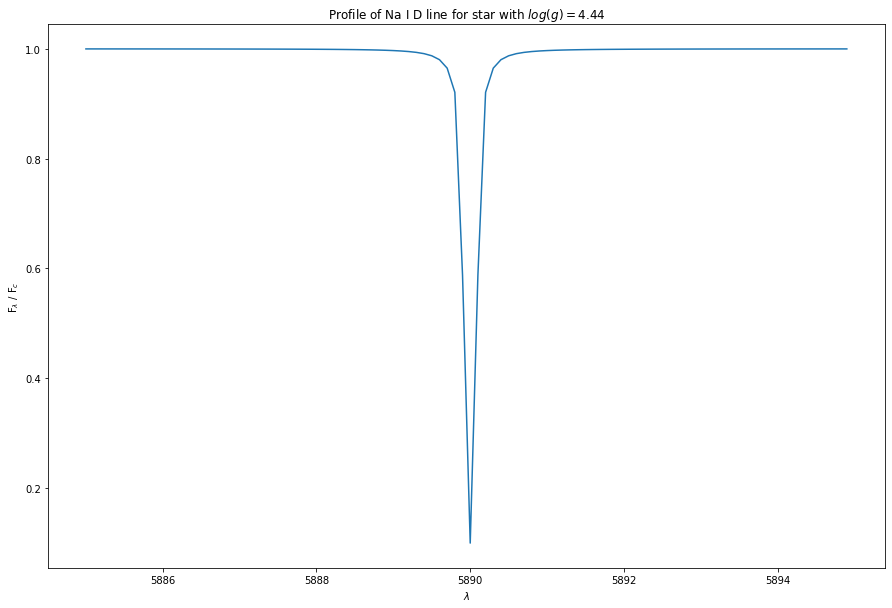

In [ ]:
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, frac)
plt.xlabel('$\lambda$')
plt.ylabel('F$_{\lambda}$ / F$_{c}$')
plt.title('Profile of Na I D line for star with $log(g)=4.44$')

# b) Plotting the Na I D line for low gravity star

In [ ]:
log_g = 2.5
metallicity = 0
g = 10 ** log_g

## Calculating the P$_{g}$ and P$_{e}$ and the number densities

In [ ]:
total_p = []
radiation_p = []

for mass in masses:
  total_p.append(mass * g)

for temp in temps:
  radiation_p.append(2.52 * 10 ** (-15) * temp ** 4)

P_g = [total_p[i] - radiation_p[i] for i in range(len(total_p))]

P_es = []

for i in range(len(temps)):
  P_guess = 1000
  num = 0 # numerator
  den = 0 # denominator
  
  # print(theta)
  for element in abundance.keys():
    for _ in range(1000):
      theta = 5040 / temps[i]
      partition_fn_ionized = get_partition_fn(element + '+', theta)
      partition_fn = get_partition_fn(element, theta)
      
      phi_element = 0.6665 * partition_fn_ionized * temps[i] ** (5/2) * 10 ** (-1 * theta * ionization_potential[element]) / partition_fn

      
      num = num + abundance[element] * (phi_element / P_guess) / (1 + (phi_element / P_guess))
      den = den + abundance[element] * (1 + ((phi_element / P_guess) / (1 + phi_element / P_guess)))
  

      P_e = P_g[i] * num / den
      P_guess = P_e
      
  P_es.append(P_e)

In [ ]:
N_e = [P_es[i] / (K * temps[i]) for i in range(len(temps))]
log_N_e = [math.log10(n) for n in N_e]
N_tot = [(P_g[i] - P_es[i]) /  (K * temps[i]) for i in range(len(temps))]
log_N_tot = [math.log10(n) for n in N_tot]
total_abundance = 0
for element in abundance.keys():
  total_abundance = total_abundance + abundance[element]
N_H = [N_tot[i] / total_abundance for i in range(len(N_tot))]
log_N_H = [math.log10(n) for n in N_H]
N_element = {}
for element in abundance:
  number_density = []
  for i in range(len(temps)):
    N = abundance[element] * N_H[i]
    number_density.append(N)
  N_element[element] = number_density
N_neutral_Na = []
for i in range(len(temps)):
  theta = 5040 / temp
  phi = 0.6665 * get_partition_fn('Na', theta) / get_partition_fn('Na' + '+', theta) \
        * temps[j] ** (5/2) * 10 ** (-1 * theta * ionization_potential['Na'])
  N_neutral_Na.append(N_element['Na'][i] / (1 + phi / P_es[i]))

## Computing the gamma for the new low gravity star

Text(0, 0.5, '$\\gamma$')

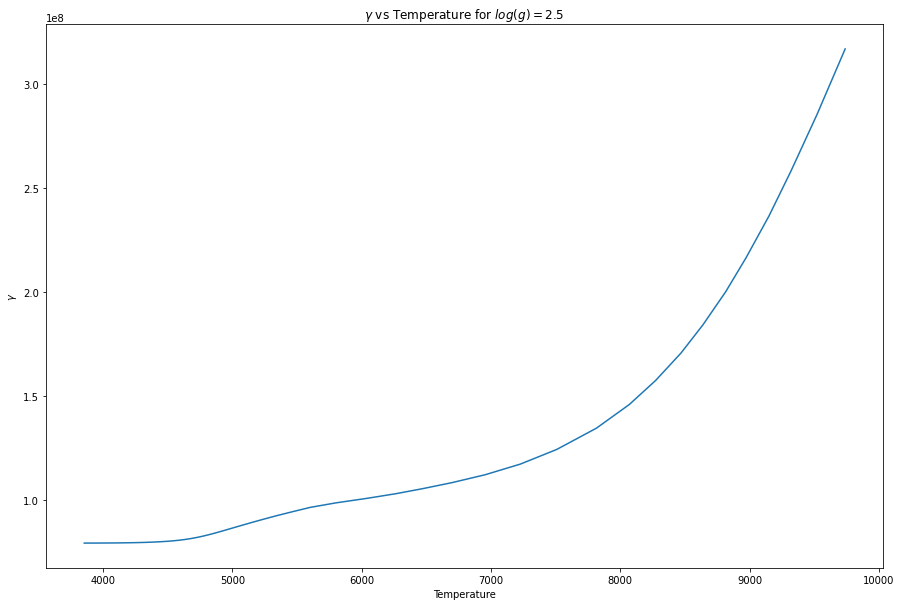

In [ ]:
log_C_4 = -15.17
log_C_6 = -31.7
log_gamma_nat = 7.9
gamma_nat = 10 ** log_gamma_nat
log_P_e = [math.log10(P_es[i]) for i in range(len(temps))]
log_P_g = [math.log10(P_g[i]) for i in range(len(temps))]
wavelength = 5890
mu_Na = 23
doppler_width = [4.301 * 10 ** (-7) * wavelength * (temp / mu_Na) for temp in temps]
f = 0.6546
delta_wavelength = 0.1
wavelengths = np.arange(5885, 5895, 0.1)
log_gamma_4 = []
log_gamma_6 = []
for i in range(len(temps)):
  log_gamma_4.append(19 + (2 / 3) * log_C_4 + log_P_e[i] - (5 / 6) * math.log10(temps[i]))
  log_gamma_6.append(19.6 + 0.4 * log_C_6 + log_P_g[i] - 0.7 * math.log10(temps[i]))

gamma_4 = [10 ** gamma for gamma in log_gamma_4]
gamma_6 = [10 ** gamma for gamma in log_gamma_6]

gamma = [gamma_nat + gamma_4[i] + gamma_6[i] for i in range(len(temps))]
plt.figure(figsize=[15, 10])
plt.plot(temps, gamma)
plt.title('$\gamma$ vs Temperature for $log(g)=2.5$')
plt.xlabel('Temperature')
plt.ylabel('$\gamma$')

## Computing the Hjerting function for the low gravity atmosphere

Text(0.5, 1.0, 'H(u, a) vs $\\lambda$ at $log(g)=2.5$ and approx. Solar T$_{eff}$')

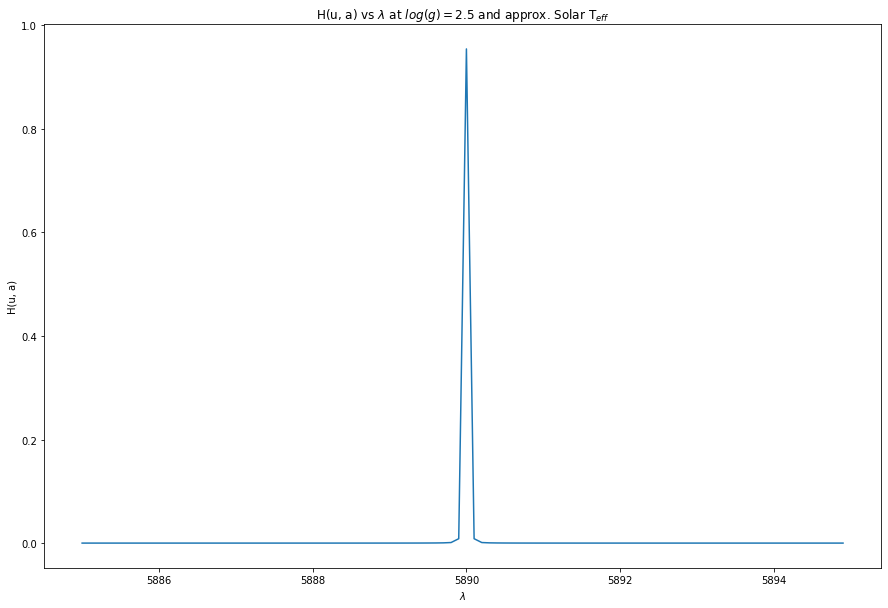

In [ ]:
H2 = []

for w in wavelengths:
  H_small = []
  for i in range(len(temps)):
    doppler_width = 4.301 * 10 ** (-7) * wavelength * ((temps[i] / mu_Na) ** 0.5)
    a = 2.65 * 10 ** (-20) * gamma[i] * w ** 2 / doppler_width
    u = (w - wavelength) / doppler_width
    H_small.append(hjert(u, a))
  H2.append(H_small)
H2 = np.array(H)
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, H2[:, 45])
plt.xlabel('$\lambda$')
plt.ylabel('H(u, a)')
plt.title('H(u, a) vs $\lambda$ at $log(g)=2.5$ and approx. Solar T$_{eff}$')

## Calculating l$_{ν}$

Text(0.5, 1.0, 'l$_{\\lambda}$ vs $\\lambda$ at $log(g)=2.5$ and approx. Solar T$_{eff}$')

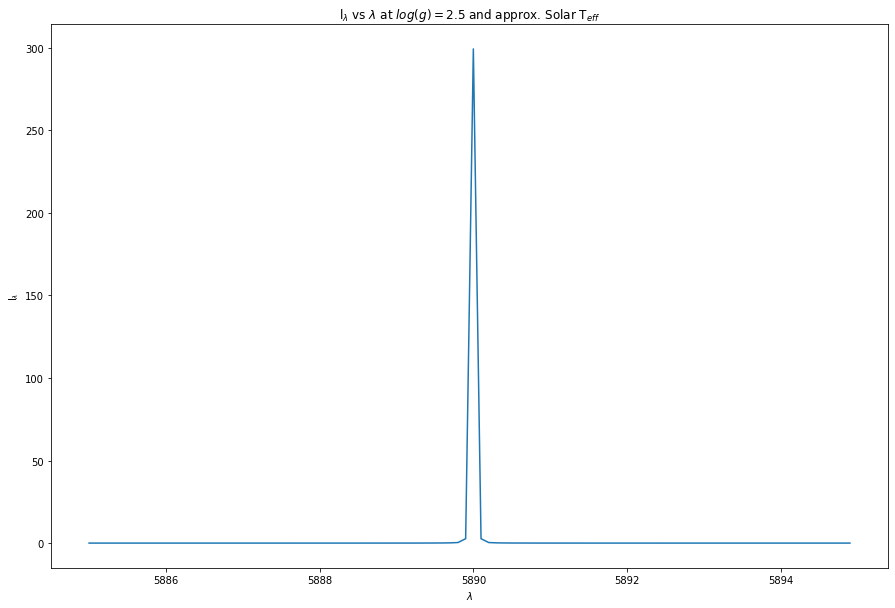

In [ ]:
h = 6.62 * 10 ** (-27)
c = 2.99 * 10 ** (10)
g_Na_1 = 2
sum_weights = 0
for element in abundance.keys():
  sum_weights = sum_weights + abundance[element] * atomic_weight[element]
l_low_g = []
for i in range(len(wavelengths)):
  l_w = []
  for j in range(len(temps)):
    theta = 5040 / temps[j]
    phi = 0.6665 * get_partition_fn('Na', theta) / get_partition_fn('Na' + '+', theta) \
      * temps[j] ** (5/2) * 10 ** (-1 * theta * ionization_potential['Na'])
    N_neutral = N_element['Na'][j] / (1 + phi / P_es[j])
    chi = 1.24 * 10 ** 4 / wavelengths[i]
    N_ground = N_neutral * g_Na_1 / get_partition_fn('Na', theta)
    doppler_width = 4.301 * 10 ** (-7) * wavelength * ((temps[j] / mu_Na) ** 0.5)
    l_w.append(4.995 * 10 ** (-21) * wavelength ** 2 * abundance['Na'] * f * N_ground * H2[i][j] * (1 - 10 ** (-chi * theta)) / \
              (sum_weights * N_element['Na'][j] * doppler_width))
  l_low_g.append(l_w)
l_low_g = np.array(l)
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, l_low_g[:, 45])
plt.xlabel('$\lambda$')
plt.ylabel('l$_{\lambda}$')
plt.title('l$_{\lambda}$ vs $\lambda$ at $log(g)=2.5$ and approx. Solar T$_{eff}$')

## Calculating the continuous absorption coefficients

In [ ]:
# H- bound-free

a_0 = 1.99654
a_1 = -1.18267 * 10 ** (-5)
a_2 = 2.64243 * 10 ** (-6)
a_3 = -4.40524 * 10 ** (-10)
a_4 = 3.23992 * 10 ** (-14)
a_5 = -1.39568 * 10 ** (-18)
a_6 = 2.78701 * 10 ** (-23)


k_H_minus_bf =[]
for w in wavelengths:
  alpha_bf = a_0 + (a_1 * w) + (a_2 * w ** 2) + (a_3 * w ** 3) + (a_4 * w ** 4) + (a_5 * w ** 5) + (a_6 * w ** 6)
  k_H_minus_bf_small = []
  for i in range(len(temps)):
    theta = 5040 / temps[i]
    k_H_minus_bf_small.append(4.158 * 10 ** (-10) * alpha_bf * P_es[i] * theta ** (5/2) * 10 ** (0.754 * theta) * 10 ** (-18))
  k_H_minus_bf.append(k_H_minus_bf_small)

# H- free-free
k_H_minus_ff = []
for w in wavelengths:
  f_0 = -2.2763 - 1.6850 * math.log(w, 10) + 0.76661 * math.log(w, 10) ** 2 - 0.053346 * math.log(w, 10) ** 3
  f_1 = 15.2827 - 9.2846 * math.log(w, 10) + 1.99381 * math.log(w, 10) ** 2 - 0.142631 * math.log(w, 10) ** 3
  f_2 = -197.789 + 190.266 * math.log(w, 10) - 67.9775 * math.log(w, 10) ** 2 + 10.6913 * math.log(w, 10) ** 3 - 0.625151 * math.log(w, 10) ** 4
  k_H_minus_ff_small = []
  for i in range(len(temps)):
    theta = 5040 / temps[i]
    k_H_minus_ff_small.append(10 ** (-26) * P_es[i] * 10 ** (f_0 + f_1 * math.log(theta, 10) + f_2 * math.log(theta, 10) ** 2))
  k_H_minus_ff.append(k_H_minus_ff_small)

# electron scattering
alpha_e = 0.6648 * 10 ** (-24)
sum_abundances = 0
for element in abundance.keys():
  sum_abundances = sum_abundances + abundance[element]
k_e = []
for w in wavelengths:
  k_e_small = []
  for i in range(len(temps)):
    k_e_small.append(alpha_e * P_es[i] * sum_abundances / (P_g[i] - P_es[i]))
  k_e.append(k_e_small)

k_total_low_g = []
for i in range(len(wavelengths)):
  k_total_small = []
  for j in range(len(temps)):
    k_total_small.append((k_H_bf[i][j] + k_H_minus_bf[i][j] + k_H_minus_ff[i][j] + k_e[i][j]) / (1.66 * 10 ** -24))
  k_total_low_g.append(np.array(k_total_small))
k_total_low_g = np.array(k_total_low_g)
# print(k_total_low_g[:, 44])

## Calculating the flux ratio

In [ ]:
import scipy.special as sc
f_l_low_g = []
f_c_low_g = []
frac_low_g = []
tau_line_low_g = []
tau_cont_low_g = []
for i in range(len(wavelengths)):
  sum_l = 0
  sum_c = 0
  for j in range(len(temps)):
    numerator = (2 * h * c ** 2) / ((wavelengths[i] * 10 ** -8) ** 5)
    denominator = math.exp((h * c) / ((wavelengths[i] * 10 ** -8) * K * temps[j])) - 1
    source_fn = numerator / denominator
    tau_l = (l_low_g[i][j] + k_total_low_g[i][j]) * masses[j]
    tau_c = k_total_low_g[i][j] * masses[j]
    tau_prev_l = 0
    tau_prev_c = 0
    if j != 0:
      tau_prev_l = (l_low_g[i][j - 1] + k_total_low_g[i][j - 1]) * masses[j - 1]
      tau_prev_c = k_total_low_g[i][j - 1] * masses[j - 1]
    del_tau_l = tau_l - tau_prev_l
    del_tau_c = tau_c - tau_prev_c
    expo_fn_l = sc.expn(2, tau_l)
    expo_fn_c = sc.expn(2, tau_c)
    #expo_fn_l = quad(expo_integrand, 1, np.inf, args=(2, tau_l))[0]
    #expo_fn_c = quad(expo_integrand, 1, np.inf, args=(2, tau_c))[0]
    sum_l = sum_l + (source_fn * expo_fn_l * del_tau_l)
    sum_c = sum_c + (source_fn * expo_fn_c * del_tau_c)
  f_l_low_g.append(sum_l)
  f_c_low_g.append(sum_c)
  frac_low_g.append(sum_l / sum_c)

Text(0.5, 1.0, 'Flux profile of Na I D line for star with $log(g)=2.5$')

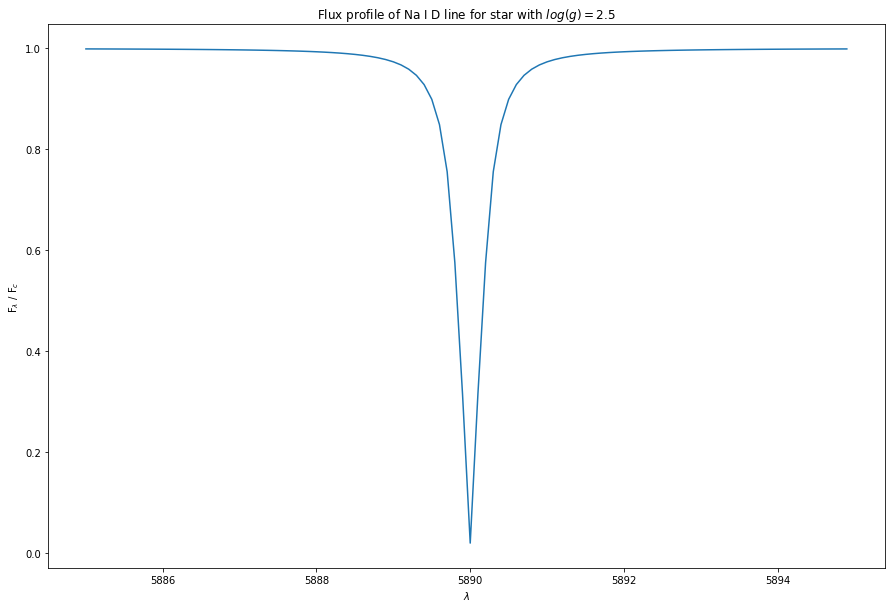

In [ ]:
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, frac_low_g)
plt.ylabel('F$_{\lambda}$ / F$_{c}$')
plt.xlabel('$\lambda$')
plt.title('Flux profile of Na I D line for star with $log(g)=2.5$')

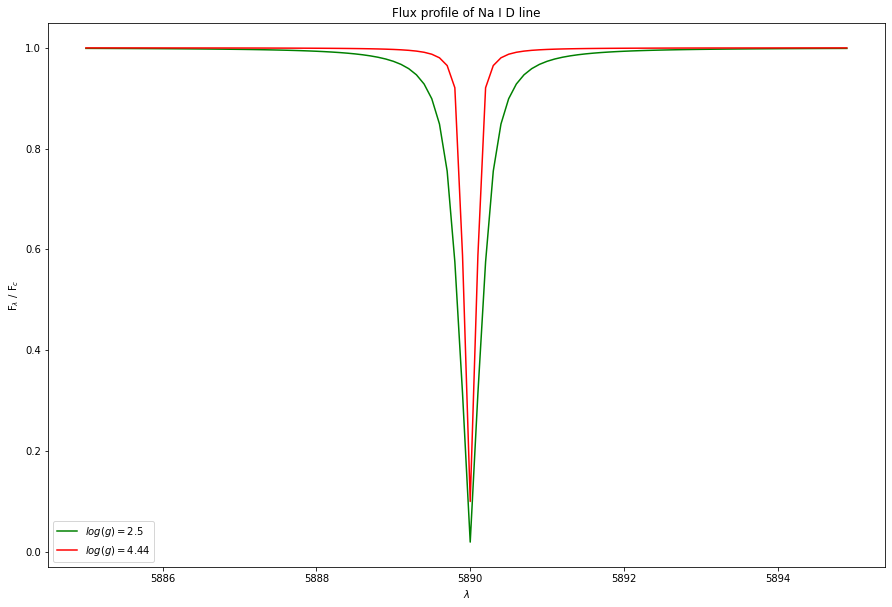

In [ ]:
plt.figure(figsize=[15, 10])
plt.plot(wavelengths, frac_low_g, c='g', label='$log(g)=2.5$')
plt.plot(wavelengths, frac, c='r', label='$log(g)=4.44$')
plt.ylabel('F$_{\lambda}$ / F$_{c}$')
plt.xlabel('$\lambda$')
plt.title('Flux profile of Na I D line')
plt.legend()